# Simulating Capsid Self-Assembly with HOOMD

In this tutorial, we will demonstrate how to use HOOMD to simulate the self-assembly of a simple capsid. Our target capsid will be the dodecahedron, made up of 12 identical pentagonal faces. We will see how to model a rigid pentagonal subunit, set its interactions such that it will assemble into a capsid, and perform the simulation using HOOMD's Langevin integrator. 

# Requirements 

HOOMD-blue Version 3 (https://anaconda.org/conda-forge/hoomd)
Note: this may still work with version 4 (untested), but definitely will not work with version 2.

gsd library (https://anaconda.org/conda-forge/gsd)

numpy (pip install numpy)

matplotlib (pip install matplotlib)



# Setup

First we import all of the libraries that we will need, namely HOOMD and numpy, as well as matplotlib for the visualization. 

We then define a few functions that will help visualize what our simulation box and pentagonal subunits look like. This is not too important, so don't worry about reading through these functions. 


In [2]:
import hoomd, gsd.hoomd
import numpy as np
import itertools
import math
import datetime

import warnings

%matplotlib inline
import matplotlib
# matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt 
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors


def fixPeriodic(V, N, L):
    #vertices are potentially on opposite sides of domain b/c of periodicity. fix this
    #max distance in pentagon is phi=1.618
    #attractors are distance 1.175 apart, so max dist is 1.9

    max_diff = 1.93  #max distance allowed for particles in the rigid pentagon 

    #loop over each body, compare coordinates of each vertex to the first, check if bigger
    #than the max allowed
    for body in range(N):
        for vertex in range(1,5):
            for d in range(3):

                diff = V[body][vertex][d] - V[body][0][d]

                if (np.abs(diff) > max_diff):
                    s = diff / np.abs(diff)
                    V[body][vertex][d] += -s*L[d]
    
    return



def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    return



def plotFrame(file, frame, snapshot=None):
    #use matplotlib to plot the structure
    
    if snapshot is not None:
        snap = snapshot
    else:
        #get the desired snapshot from the file
        with gsd.hoomd.open(name=file, mode="r") as gsd_file:
            snap = gsd_file[frame]

    #get the box data
    box = snap.configuration.box
    L = [box[0], box[1], box[2]]

    #get total number of particles
    Ntot = snap.particles.N
    
    #get index of 'A' type particles
    A_index = np.where(np.array(snap.particles.types) == 'A')[0][0]

    #get the number of particles of type A
    particle_types = snap.particles.typeid
    N = len(snap.particles.typeid[particle_types == A_index])

    #init list to store vertices
    V = np.zeros((N, 5, 3))

    #get the vertices of each pentagon via the attractor coordinates
    count = 0
    body = 0
    for particle in range(Ntot):
        if (particle_types[particle] == A_index):
            vertex = snap.particles.position[particle]
            V[body][count] = np.array(vertex)
            count += 1


        if (count == 5):
            body += 1
            count = 0

    #fix any jumps in the coordinates due to periodic BCs in the simulation
    fixPeriodic(V,N,L)
    M = np.amax(np.amax(V,axis=1),axis=0)
    m = np.amin(np.amin(V,axis=1),axis=0)

    #loop over the bodies and construct pentagons using the vertices, fill, plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for body in range(N):
        vtx = V[body]
        pent = a3.art3d.Poly3DCollection([vtx])
        pent.set_color("g")
        pent.set_edgecolor("k")
        ax.add_collection(pent)

    #plot result
    ax.set_xlim(m[0], M[0])
    ax.set_ylim(m[1], M[1])
    ax.set_zlim(m[2], M[2])
    ax.view_init(35, -80)
    set_axes_equal(ax)
    plt.show()
    
    return

# Set Input Parameters

Here we set all of the tunable input parameters that change the behavior of the simulation. Leave these parameters at their default values unless a comment says you can change it. I would recommend keeping them as is if you want to guarantee your simulation actually forms a capsid!

In [3]:
# The following are fixed. DO NOT CHANGE!
rho = 2.5  #governs the interaction range of attractive potential
kT  = 1.0  #temperature of the simulation
dt  = 0.001 #time step for simulation, increasing will cause instability
num_steps = 2500000 #number of time steps -> Tf = 2500
capsomers = 64 #number of subunits. this should preferably be a perfect cube. 
               #increasing this will make the simulation take longer

# The following parameters can be changed. Keep defaults for a guaranteed assembly
box_size = 15 #do not make smaller than 15. making it larger will increase time needed to assemble. 
E_bond = 6.0 #strength of attractive interaction. smaller -> no nucleation. larger -> blob of subunits
seed  = 123 # seed for random number generation. different seed, different trajectory

# Creating the Subunit

Our first order of business is to construct the pentagonal subunits. We do this in HOOMD by creating a Rigid Body object as a collection of point particles. This requires two things; the position and type of each particle making up the body.

For our model, the subunit will consist of 5 attractor atoms, one at each vertex, which are responsible for binding the subunits together. We'll call these particles type "A" for "attractor", and place them in the x-y plane at the 5th roots of unity (vertices of a regular pentagon with one vertex at (1,0)). 



In [4]:
theta_5 = 2.0 * np.pi / 5.0 #chop unit circle into fifths
atom_positions = []         #init a list to store positions
#loop over 5th roots of unity and append to positions
for i in range(5):
    root_i = (np.cos(i*theta_5), np.sin(i*theta_5), 0)
    atom_positions.append(root_i)
    
#make another list to store the type of each of these particles - "A"
atom_types = ["A", "A", "A", "A", "A"]

Our pentagon is now defined. However, if we leave it at this we will find that our pentagons will simply tend to align in sheets, not form a capsid. We need some way to specify the curvature between two bonded subunits, so a closed shell can form. 

We do this by introducing two fictitious particles above and below each subunit, called a Top (T) particle and a Bottom (B) particle. These particles will repel eachother such that when two subunits bind, they do so at a preferred angle, consistent with the curvature of a dodecahedron. 

In [5]:
#append the top and bottom particles to the list
atom_types.append("T")
atom_types.append("B")

#set positions for these particles, 0.5 units above and below the subunit
atom_positions.append((0,0,0.5))
atom_positions.append((0,0,-0.5))

Now we create the HOOMD Rigid Body object, which will enforce the rigid body constraints on our subunits during the simulation. To do this, we also need to specify a few extra quantities for each particle; orientations, charges, and diameter. These do not matter for us, so we will supply some default values. 

In [6]:
'''
Orientations don't matter for our constituent particles. 
There are no charges present here. 
Diameters are set to the interaction ranges for each particle, which we set later, 
but they do not actually influence the simulation at all. 
'''
orientations = [(1,0,0,0)]*7
charges      = [0.0]*7
diameters    = [0.2, 0.2, 0.2, 0.2, 0.2, 2.1, 1.8]

#create the Rigid Body object. need two copies for later. 
rigid = hoomd.md.constrain.Rigid()
rigid_eq = hoomd.md.constrain.Rigid()

#Add the pentagonal subunits to rigid, name them "Capsomer"
name = "Capsomer"
rigid.body[name] = {
     "constituent_types": atom_types,
     "positions":         atom_positions,
     "orientations":      orientations, 
     "charges":           charges,
     "diameters":         diameters
}
rigid_eq.body[name] = {
     "constituent_types": atom_types,
     "positions":         atom_positions,
     "orientations":      orientations, 
     "charges":           charges,
     "diameters":         diameters
}

/home/anthony/anaconda3/envs/compute3/lib/python3.10/site-packages/hoomd/md/constrain.py:44: FutureWarning: The charges key is deprecated and will be removed in hoomd 4.0.
  warnings.warn(msg, FutureWarning)
/home/anthony/anaconda3/envs/compute3/lib/python3.10/site-packages/hoomd/md/constrain.py:44: FutureWarning: The diameters key is deprecated and will be removed in hoomd 4.0.
  warnings.warn(msg, FutureWarning)


The final thing we need to know about our subunit is its inertia tensor. HOOMD requires that the inertia tensor is computed in the body frame, i.e. is diagonal. 

In general, we will need to compute the inertia tensor as a sum of point particles, diagonalize it, and rotate the atom positions by the corresponding eigenvectors to align the rigid body along its principal axes of rotation. 

In this case, the inertia tensor is already diagonal, so we don't need to worry about this. 

In [7]:
#compute the inertia tensor for the pentagonal subunit 
#as a sum over each vertex particle

#convert list of positions to nparray for calculation
r   = np.array(atom_positions, dtype=float)

#compute the first contribution to the inertia tensor
moi = (np.dot(r[0], r[0]) * np.identity(3) - np.outer(r[0], r[0]))

#loop over other particles - just the vertices
for i in range(1,5):
    moi += (np.dot(r[i], r[i]) * np.identity(3) - np.outer(r[i], r[i]))
    
#print the inertia tensor to confirm it is diagonal
print(moi) #xy component may be nonzero, but this is numerical roundoff error

#moi is already diagonal, extract these components
Ixx = moi[0][0]
Iyy = moi[1][1]
Izz = moi[2][2]
inertia_tensor = [Ixx, Iyy, Izz]

[[ 2.50000000e+00 -1.11022302e-16  0.00000000e+00]
 [-1.11022302e-16  2.50000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  5.00000000e+00]]


# Initializing the Simulation

Now that we've defined our subunit, we need to create and initialize the simulation. We will do this by first creating a lattice and placing one subunit per lattice site. Starting a simulation from this configuration introduces a bias to the system, so we will perform an equilibration to randomize the starting positions and orientations of the subunits. 

# Creating the Starting State


In [8]:
#create a HOOMD snapshot and populate it with information about our simulation and subunits
snapshot = gsd.hoomd.Frame()
snapshot.particles.N           = capsomers                                 #number of subunit
snapshot.configuration.box     = [box_size, box_size, box_size, 0, 0, 0]   #square box with set size
snapshot.particles.orientation = [(1,0,0,0)] * capsomers                   #orientations set to default
snapshot.particles.types       = [name] + list(set(atom_types))            #[rigid body name, particle types]
snapshot.particles.typeid      = [0] * capsomers                           #index in types of each subunit
snapshot.particles.moment_inertia = inertia_tensor * capsomers             #inertia tensor of each subunit

We have seen most of these quantities already, so this should be mostly straight-forward. We are providing information about each subunit in the simulation. Since each subunit is the same, we are copying the data "capsomers" times. This is what the ' * capsomers' is doing. For example, if we do ["Hi"]*3 we get ["Hi", "Hi", "Hi"].

Note that we need to augment the beginning of the atom_types list with the subunit's name to tell HOOMD about the rigid bodies. We also convert atoms types to a set and back to a list. This removes duplicates, since we only want one copy of each type of pseudoatom.

The typeid field is the index in the atom_types list of the rigid subunit, in this case "Capsomer". If there is only one type of subunit, this will always be 0. If you have many subunit types, you must specify the index of the rigid body name for each particle. 

Now we just need to set the subunits positions. The following block of code generates the coordinates of a cubic lattice that fits in the box. 

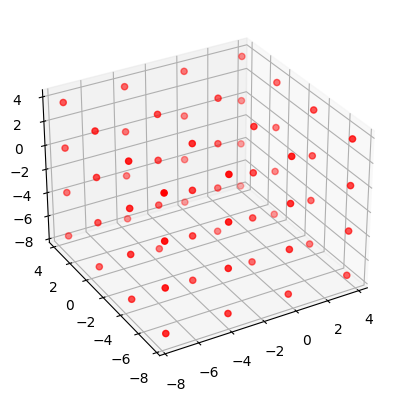

In [9]:
#take cube root of number of subunits to get how many in each dimension - round up to overcount
particle_per_dim = int(np.ceil(capsomers ** (1/3)))

#init storage for positions, each subunit needs x,y,z coordinates
positions = np.zeros((capsomers, 3), dtype=float)

#discretize an interval with equally spaced points on [-box_size/2, box_size/2]
x1 = np.linspace(-box_size / 2.0, box_size / 2, particle_per_dim+1)[:-1]

#use coordinates in x1 to generate points in all 3 dimensions
c  = 0
for i in range(particle_per_dim):
    for j in range(particle_per_dim):
        for k in range(particle_per_dim):


            positions[c][0] = x1[i]
            positions[c][1] = x1[j]
            positions[c][2] = x1[k]
            c+=1

            if c >= capsomers:
                break

#visualize the lattice
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(positions[:,0], positions[:,1], positions[:,2], c='red')
ax.view_init(30, -120)
plt.show()


Now that we have our lattice, we fill in the position data in our snapshot, and then we save the snapshot in a file called 'lattice.gsd'. 

In [10]:
#add the lattice positions to the snapshot
snapshot.particles.position = positions

#save the snapshot as a gsd file
with gsd.hoomd.open(name='lattice.gsd', mode='w') as f:
    f.append(snapshot)


ValueError: mode must be 'wb', 'wb+', 'rb', 'rb+', 'xb', 'xb+', or 'ab'

# Equilibrating the Starting State

Now that we have a lattice of subunits to start from, we want to perform an equilibration step to generate the initial configuration for our simulation. The steps to do this are very similar to running the full simulation. 

First, we set which device will be running the calculations and create a simulation object on it. 
We then construct an integrator to solve the equations of motion and add it to the simulation operations. Note that the integrator needs to know about the rigid bodies, and we have to tell it to integrate over rotational degrees of freedom. 
Finally, we tell the integrator which bodies to integrate, what method to use (Langevin here), and set a temperature.


In [ ]:
#set the simulation device
my_device_eq = hoomd.device.CPU() #If you have a GPU available, change CPU() to GPU() for large speedup!

#create a simulation object to manage all the simulation setup
simulation_eq = hoomd.Simulation(device=my_device_eq, seed=seed)

#create an integrator to update the subunits every timestep
integrator_eq = hoomd.md.Integrator(dt=dt, integrate_rotational_dof=True)
integrator_eq.rigid = rigid_eq
simulation_eq.operations.integrator = integrator_eq

#filter which rigid bodies this integrator manages, and set integrator type
filtered_bodies = hoomd.filter.Rigid(("center","free"))
L_int_eq = hoomd.md.methods.Langevin(filter=filtered_bodies, kT=kT)
integrator_eq.methods.append(L_int_eq)


Next, we have to specify a potential for the equilibration. We want our subunits to thermalize their positions and orientations without overlapping each other. To do this, we construct a purely repulsive potential between the subunits and let them undergo thermal fluctuations. 

In [ ]:
#create a neignborlist for potential calculations. This speeds up pairwise distance checks
cell = hoomd.md.nlist.Cell(buffer=3.0, exclusions=['body']) #particle in the same rigid body do not need to be checked

#initialize a Lennard-Jones potential as the repulsive equilibration potential
lj_eq = hoomd.md.pair.LJ(nlist=cell)

#set an effective repulsive distance for the subunits, and a cutoff for a WCA potential
r_dist = 1.25 * 2.1
r_cut  = r_dist * 2.0 ** (1.0/6.0)

#set a repulsive interaction between each pair of atom types, with strength 1
for type1 in [name]+list(set(atom_types)):
    for type2 in [name]+list(set(atom_types)):
        
        lj_eq.params[(type1,type2)] = dict(epsilon=1, sigma=r_dist)
        lj_eq.r_cut[ (type1,type2)] = r_cut
        
#add the potential to the integrator
integrator_eq.forces.append(lj_eq)

We are almost ready to run the equilibration. The last thing we need to do is tell the simulation object to save the final frame of the equilibration run to use as our initial condition. This is done in HOOMD through Writers. We can also use Loggers to measure how far into the simulation we are, to estimate how much longer it will take. 

In [ ]:
eq_steps = 200000 #number of equilibration time steps

#make a logger that outputs the frame at the final frame of equilibration
gsd_writer_eq = hoomd.write.GSD(filename='equilibrated_start.gsd',
                                trigger=hoomd.trigger.Periodic(eq_steps-1),
                                mode='w')
#append the logger to the simulation object
simulation_eq.operations.writers.append(gsd_writer_eq)

#make a logger to track progress and efficiency of simulation
log_period = int(eq_steps / 20)
logger_eq  = hoomd.logging.Logger(categories=['scalar'])
logger_eq.add(simulation_eq, quantities=['timestep','tps'])
sim_writer = hoomd.write.Table(trigger=hoomd.trigger.Periodic(log_period),
                               logger=logger_eq)
simulation_eq.operations.writers.append(sim_writer)

Now we just create the simulation and run it. We will visualize the subunits on the lattice before we do. 

You will notice as the simulation runs that every 5% of the way done it will print out the current timestep number, as well as the number of timesteps per second that are being computed, thanks to our Logger.

In [ ]:
#create the simulation state from the lattice. add the rigid bodies
simulation_eq.create_state_from_gsd(filename='lattice.gsd')
rigid.create_bodies(simulation_eq.state)

In [ ]:
#visualize the subunits on the lattice
plotFrame(None, None, simulation_eq.state.get_snapshot())

In [ ]:
#run the equilibration
simulation_eq.run(eq_steps)

In [ ]:
#plot the equilibrated configuration
plotFrame('equilibrated_start.gsd',-1)

# Running the Assembly Simulation

We now have a starting configuration to run our assembly simulation from. Setting up the full simulation is almost identical to setting up the equilibration. The only difference here is that we need to set up the attractive interaction potential rather than a repsulive equilibration potential. 

The next cell will set up our simulation the same way as the equilibrator. The following cell will implement the attractive potential. Finally, we make writers and loggers again. This time, we save intermediate frames so we can make a movie of the assembly later.

In [ ]:
#set the simulation device
my_device = hoomd.device.CPU() #If you have a GPU available, change CPU() to GPU() for large speedup!

#create a simulation object to manage all the simulation setup
simulation = hoomd.Simulation(device=my_device, seed=seed)
#set the timestep to 0, or else it will start from the final time step of the equilibration
simulation.timestep = 0
#create the initial condition from the equilibration
simulation.create_state_from_gsd('equilibrated_start.gsd', frame=-1)

#create an integrator to update the subunits every timestep
integrator = hoomd.md.Integrator(dt=dt, integrate_rotational_dof=True)
integrator.rigid = rigid
simulation.operations.integrator = integrator

#filter which rigid bodies this integrator manages, and set integrator type
filtered_bodies = hoomd.filter.Rigid(("center","free"))
L_int = hoomd.md.methods.Langevin(filter=filtered_bodies, kT=kT)
integrator.methods.append(L_int)

In [ ]:
#create the attractive potentials between A atoms, and the repulsive potential between T and B atoms

#set the top (T) and bottom (B) repsulsion parameters
top_sigma = 2.1
top_cut   = top_sigma
top_repulsion = E_bond / 4 #dont want repulsion to overcome attraction

bot_sigma = 1.8
bot_cut   = bot_sigma

#get the full list of particle types
full_type_list = [name] + list(set(atom_types))

#create a cell-based neighborlist which excludes particles in same body
cell = hoomd.md.nlist.Cell(buffer=3.0, exclusions=['body'])

#init a repulsive LJ potential and attractive Morse interaction
lj    = hoomd.md.pair.LJ(   nlist = cell, default_r_cut=3.0, mode='shift')
morse = hoomd.md.pair.Morse(nlist = cell, default_r_cut=3.0, mode='shift')

#init all the interactions to 0
lj.params[(full_type_list, full_type_list)]     = dict(epsilon=0, sigma=0)
lj.r_cut[  (full_type_list, full_type_list)]    = 0 
morse.params[(full_type_list, full_type_list)]  = dict(D0=0, r0=0, alpha=0)
morse.r_cut[  (full_type_list, full_type_list)] = 0 

#set the LJ repsulsive interactions

# T-T repsulsion
lj.params[ ("T", "T") ] = dict(epsilon=top_repulsion, sigma=top_sigma)
lj.r_cut[  ("T", "T") ] = top_cut

# T-B repsulsion
lj.params[ ("T", "B") ] = dict(epsilon=top_repulsion, sigma=bot_sigma)
lj.r_cut[  ("T", "B") ] = bot_cut

#append the LJ potential to the integrator
integrator.forces.append(lj)

#prepare values to set Morse potentials
r0 = 0.2   #equilibrium bond distance between attractors
alpha = rho / r0   #set range parameter according to alpha and r0

# A-A attraction
morse.params[ ("A", "A") ] = dict(D0=E_bond, r0=r0, alpha=alpha)
morse.r_cut[  ("A", "A") ] = 2.0

#add the morse potential to the integrator
integrator.forces.append(morse)

In [ ]:
#set number of frames between dumping configurations and logging statsistics
t_dump = 1000 #output configuration every 1 unit of simulation time
t_log  = 100000 #output progress every 100 units of simulation time

#define a writer for the gsd file and add it to simulation
gsd_writer = hoomd.write.GSD(filename="dodec_trajectory.gsd",
                             trigger=hoomd.trigger.Periodic(t_dump),
                             mode='w')
simulation.operations.writers.append(gsd_writer)

#define a logger/writer for the simulation details
logger = hoomd.logging.Logger(categories=['scalar','string'])
logger.add(simulation, quantities=['timestep', 'tps', 'walltime'])


#make a table of quantities to log and add it to sim
sim_writer = hoomd.write.Table(trigger=hoomd.trigger.Periodic(t_log), 
                               logger = logger)
simulation.operations.writers.append(sim_writer)

We are all set. Now we just have to run the simulation.

This make take some time to run long enough for a capsid to assemble. On the order of 15-30 minutes on a decent CPU, or around 8-10 minutes on a GPU. After it is done, we will visualize the final frame to see if any capsids have formed. 

Note: I had issues getting interactive plots to work in my notebook, so you cannot pan around to look at different angles. If you would like to do so, I have provided an auxiliary file called 'viz.py' that you can run locally that performs that same plotting used here. I have also included a file 'movie.py' that creates an animation of the assembly using every frame in the trajectory. You need to run these from the same folder that contains this notebook.

In [ ]:
#run the simulation
simulation.run(num_steps)

In [ ]:
#visualize the final frame, look at your capsids!
plotFrame('dodec_trajectory.gsd', -1)